# Local Variacne

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import shap
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import seaborn as sns
import sys
# Parent directory import
current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))  # ../
sys.path.append(parent_dir)
from dataset.FF import FaceForensicsDataset
from model.DefocusNet_backbone_defocus_gt import DefocusMapGenerator  

# --------------------------- Setting ---------------------------
FF_RGB_ROOT = "/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0"
FAKE_TYPE = "Deepfakes"  # Deepfakes, Face2Face, FaceSwap, NeuralTextures
IMG_SIZE = 299
BATCH_SIZE = 32

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the DefocusMapGenerator instance
defocus_generator = DefocusMapGenerator().to(device)


# --------------------------- Dataset ---------------------------
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
# Load the dataset
real_test_dataset = FaceForensicsDataset(root_dir="/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0", phase="real_test_only", fake_types=["Deepfakes"], transform=transform)
fake_test_dataset = FaceForensicsDataset(root_dir="/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0", phase="fake_test_only", fake_types=["Deepfakes"], transform=transform)

# Create DataLoaders for the datasets
real_test_loader = DataLoader(real_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
fake_test_loader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

🔹 [REAL_TEST_ONLY] Deepfakes 이미지 개수: 6400
🔹 [FAKE_TEST_ONLY] Deepfakes 이미지 개수: 6400


In [ ]:
import tqdm
import numpy as np

real_defocus_maps = []
real_edge_maps = []
real_labels = []
hist_features = []
with torch.no_grad():
    for images, labels, _ in tqdm.tqdm(real_test_loader, desc="Extracting Defocus Maps"):
        images = images.to(device)
        defocus_map_gt, sparse_map, edge_map, _ = defocus_generator(images, device)
        
        hist, _ = np.histogram(defocus_map_gt.detach().cpu().numpy(), bins=32, range=(0, 1), density=True)
        hist_features.append(hist)
        real_defocus_maps.append(defocus_map_gt.cpu())
        real_edge_maps.append(edge_map.cpu())
        real_labels.extend(labels.numpy())

# (B, 1, H, W) → (N, 1, H, W)
real_defocus_maps_tensor = torch.cat(real_defocus_maps, dim=0)
real_edge_maps_tensor = torch.cat(real_edge_maps, dim=0)
real_labels = np.array(real_labels)


Extracting Defocus Maps: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


In [4]:
import tqdm
import numpy as np

fake_defocus_maps = []
fake_edge_maps = []
fake_labels = []
with torch.no_grad():
    for images, labels, _ in tqdm.tqdm(fake_test_loader, desc="Extracting Defocus Maps"):
        images = images.to(device)
        defocus_map_gt, sparse_map, edge_map, _ = defocus_generator(images, device)
        
        # defocus_map_gt = normalize_per_sample(defocus_map_gt)
        hist, _ = np.histogram(defocus_map_gt.detach().cpu().numpy(), bins=32, range=(0, 1), density=True)
        hist_features.append(hist)
        fake_defocus_maps.append(defocus_map_gt.cpu())
        fake_edge_maps.append(edge_map.cpu())
        fake_labels.extend(labels.numpy())



# (B, 1, H, W) → (N, 1, H, W)
fake_defocus_maps_tensor = torch.cat(fake_defocus_maps, dim=0)  # 텐서로 합침
fake_edge_maps_tensor = torch.cat(fake_edge_maps, dim=0)  # 텐서로 합침
fake_labels = np.array(fake_labels)  # 라벨을 numpy 배열로 변환

print(fake_defocus_maps_tensor.shape, fake_edge_maps_tensor.shape)

Extracting Defocus Maps: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]


torch.Size([6400, 1, 299, 299]) torch.Size([6400, 1, 299, 299])


In [5]:
def normalize_per_sample(x):
    B, C, H, W = x.shape
    x_flat = x.view(B, -1)
    min_val = x_flat.min(dim=1, keepdim=True)[0]
    max_val = x_flat.max(dim=1, keepdim=True)[0]
    norm = (x_flat - min_val) / (max_val - min_val + 1e-8)
    return norm.view(B, C, H, W)

In [6]:
real_defocus_maps_norm = normalize_per_sample(real_defocus_maps_tensor)
fake_defocus_maps_norm = normalize_per_sample(fake_defocus_maps_tensor)

## Local Variance Map

In [7]:
import torch.nn.functional as F

def compute_local_variance_map(defocus_tensor, window_size=15):
    """
    defocus_tensor: (N, 1, H, W) – normalized defocus maps
    return: (N, 1, H, W) – local variance map
    """
    mean = F.avg_pool2d(defocus_tensor, window_size, stride=1, padding=window_size//2)
    mean_sq = F.avg_pool2d(defocus_tensor ** 2, window_size, stride=1, padding=window_size//2)
    local_var = mean_sq - mean ** 2
    return local_var


In [8]:
real_var_maps = compute_local_variance_map(real_defocus_maps_norm)
fake_var_maps = compute_local_variance_map(fake_defocus_maps_norm)

## Defocus Vairance Map Heatmap

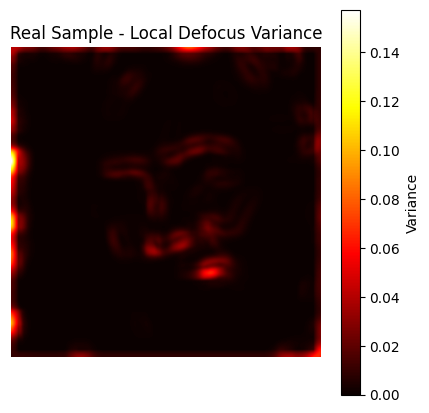

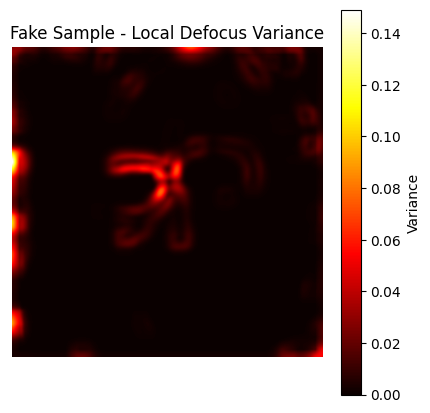

In [10]:
import matplotlib.pyplot as plt

def show_variance_heatmap(var_map_tensor, index=0, title="Local Defocus Variance"):
    """
    var_map_tensor: (N, 1, H, W)
    index: 시각화할 샘플 index
    """
    heatmap = var_map_tensor[index, 0].numpy()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, cmap='hot')
    plt.title(title)
    plt.colorbar(label='Variance')
    plt.axis('off')
    plt.show()

show_variance_heatmap(real_var_maps, index=40, title="Real Sample - Local Defocus Variance")
show_variance_heatmap(fake_var_maps, index=40, title="Fake Sample - Local Defocus Variance")


In [11]:
import matplotlib.pyplot as plt
import os
import numpy as np

def save_variance_pair(real_var_map_tensor, fake_var_map_tensor, index, save_dir):
    """
    real_var_map_tensor, fake_var_map_tensor: (N, 1, H, W)
    index for visualization
    save_dir: directory to save results
    """
    real_map = real_var_map_tensor[index, 0].cpu().numpy()
    fake_map = fake_var_map_tensor[index, 0].cpu().numpy()
    vmax = max(np.max(real_map), np.max(fake_map))  # common vmax for color normalization

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(real_map, cmap='hot', vmax=vmax)
    plt.title(f"Real Sample {index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fake_map, cmap='hot', vmax=vmax)
    plt.title(f"Fake Sample {index}")
    plt.axis('off')

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"variance_pair_{index:03d}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close()


In [12]:
SAVE_PAIRS_DIR = "./local_variance_pairs"
os.makedirs(SAVE_PAIRS_DIR, exist_ok=True)

n_samples = min(50, real_var_maps.shape[0], fake_var_maps.shape[0])

for i in range(n_samples):
    save_variance_pair(real_var_maps, fake_var_maps, i, SAVE_PAIRS_DIR)

In [13]:
from scipy.stats import ks_2samp
# 1. Compute mean local variance per image
real_var_mean = real_var_maps.mean(dim=[1, 2, 3]).cpu().numpy()
fake_var_mean = fake_var_maps.mean(dim=[1, 2, 3]).cpu().numpy()
# print(real_var_mean, fake_var_mean)
# 2. Perform KS-test
ks_stat, p_val = ks_2samp(real_var_mean, fake_var_mean)
print(ks_stat, p_val)

0.05265625 3.9034098218394596e-08


In [14]:
print("real_var_mean:", real_var_mean.mean())
print("fake_var_mean:", fake_var_mean.mean())

real_var_mean: 0.0036611257
fake_var_mean: 0.0035608006


In [16]:
print("Global minimum:", real_defocus_maps_norm.min().item())
print("Global maximum:", real_defocus_maps_norm.max().item())

Global minimum: 0.0
Global maximum: 1.0
